<a href="https://colab.research.google.com/github/raniiian21/belajar-git/blob/main/implementasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from google.colab import files

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import pandas as pd

Load Dataset

In [ ]:
path_dataset = '/content/drive/MyDrive/dataset'
image_paths = []
class_counts = defaultdict(int)

for label in ['jamur_segar', 'jamur_tidak_segar']:
    folder = os.path.join(path_dataset, label)
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append((os.path.join(folder, file), label))
            class_counts[label] += 1

print("Jumlah gambar:", len(image_paths))
print("Distribusi kelas:", dict(class_counts))


Jumlah gambar: 1000
Distribusi kelas: {'jamur_segar': 500, 'jamur_tidak_segar': 500}


Import dan inisialisasi model ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load model ResNet50 tanpa top layer untuk ekstraksi fitur
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Load dan Preprocess Batch Gambar untuk Ekstraksi Fitur


In [ ]:
# image_paths = [(path, label_string)] — misal 'jamur_segar' atau 'jamur_tidak_segar'
images = []
labels = []

for path, label in image_paths:
    try:
        img = load_img(path, target_size=(224, 224))
        img_arr = img_to_array(img)
        images.append(img_arr)
        labels.append(label)
    except Exception as e:
        print(f"❌ Gagal muat gambar: {path}, Error: {e}")

images = np.array(images)
images = preprocess_input(images)

Ekstraksi fitur menggunakan ResNet50

In [ ]:
features = resnet_model.predict(images, batch_size=20, verbose=1)  # → tampil 50/50 step jika 1000 data
X = features.reshape((features.shape[0], -1))

50/50 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step


Label Encoding

In [ ]:
# 🎯 Konversi label teks menjadi label numerik (0/1)
y = np.array([1 if l == 'jamur_segar' else 0 for l in labels])

print("✅ Fitur & label berhasil disiapkan")
print("X shape:", X.shape)      # Contoh: (1000, 2048)
print("y shape:", y.shape)      # Contoh: (1000,)
print("Distribusi label:", np.bincount(y))  # Contoh: [500 500]

✅ Fitur & label berhasil disiapkan
X shape: (1000, 2048)
y shape: (1000,)
Distribusi label: [500 500]


Training Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from pprint import pprint # Added pprint import

# Split data (stratify agar 0 dan 1 tetap seimbang)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Reduksi dimensi dengan PCA
pca = PCA(n_components=530)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.1,
    reg_lambda=1.0,
    random_state=42,
    eval_metric='logloss'
)
rf.fit(X_train_pca, y_train)
xgb.fit(X_train_pca, y_train)

print("🔍 Random Forest Classifier Configuration:")
pprint(rf.get_params())

print("\n🔍 XGBoost Classifier Configuration:")
print(xgb)  # otomatis tampilkan konfigurasi XGBoost

🔍 Random Forest Classifier Configuration:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

🔍 XGBoost Classifier Configuration:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_one

📊 Random Forest Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       100
           1       0.84      0.86      0.85       100

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200

📊 XGBoost Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       100
           1       0.86      0.88      0.87       100

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200



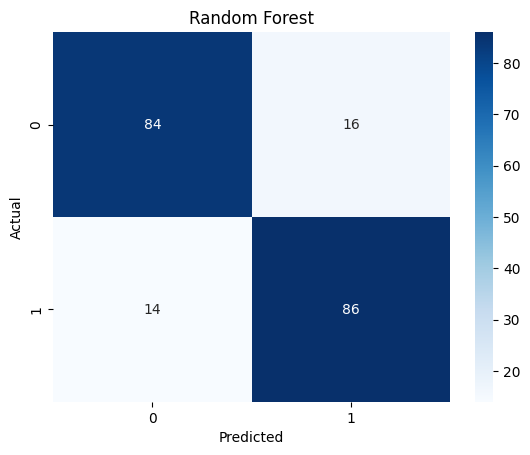

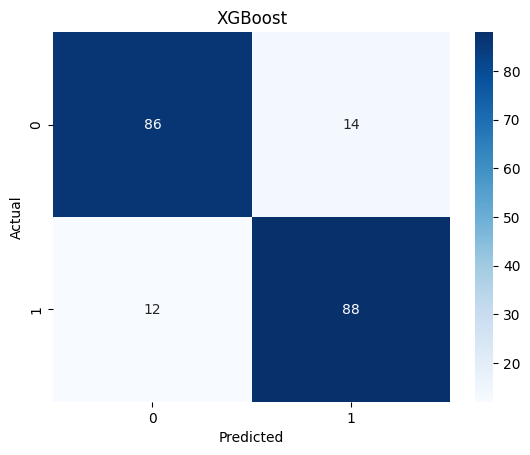

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns # Added seaborn import

# Prediksi
rf_pred = rf.predict(X_test_pca)
xgb_pred = xgb.predict(X_test_pca)

# Evaluasi
print("📊 Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

print("📊 XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

# Confusion Matrix
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion(y_test, rf_pred, "Random Forest")
plot_confusion(y_test, xgb_pred, "XGBoost")

Grafik Akurasi dan Loss Model

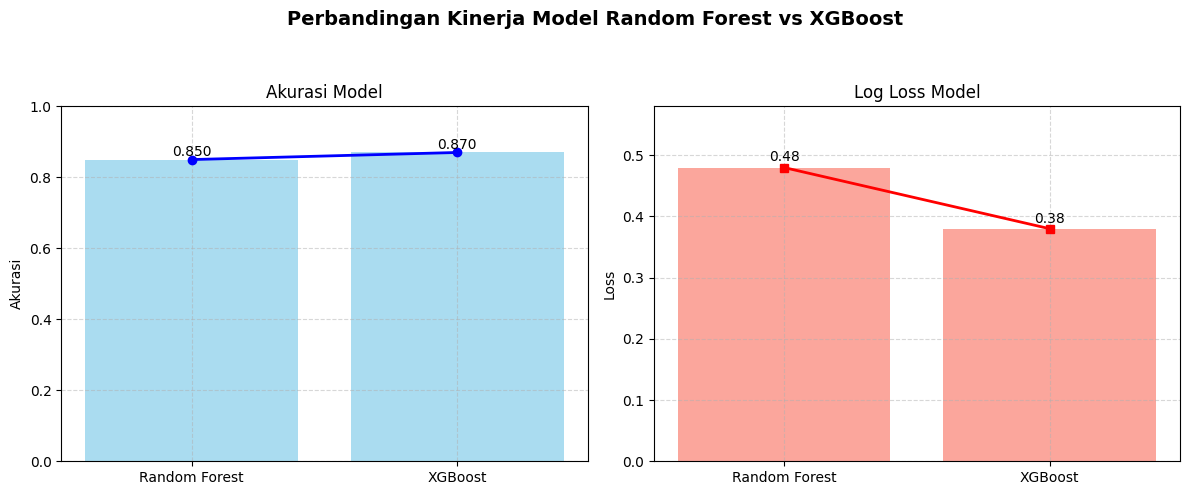

In [ ]:
import matplotlib.pyplot as plt

# ✅ Data akurasi dan log loss
akurasi_rf = 0.85
akurasi_xgb = 0.87

loss_rf = 0.48
loss_xgb = 0.38

# ✅ Nama model
model_names = ['Random Forest', 'XGBoost']

# === Plotting ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Perbandingan Kinerja Model Random Forest vs XGBoost", fontsize=14, weight='bold')

# 🎯 Subplot 1 - Akurasi
ax1.bar(model_names, [akurasi_rf, akurasi_xgb], color='skyblue', alpha=0.7)
ax1.plot(model_names, [akurasi_rf, akurasi_xgb], color='blue', marker='o', linewidth=2, label='Akurasi')
ax1.set_ylim(0, 1)
ax1.set_ylabel('Akurasi')
ax1.set_title('Akurasi Model', fontsize=12)

# Label nilai akurasi
for i, acc in enumerate([akurasi_rf, akurasi_xgb]):
    ax1.text(i, acc + 0.01, f"{acc:.3f}", ha='center', fontsize=10)

ax1.grid(True, linestyle='--', alpha=0.5)

# 🎯 Subplot 2 - Log Loss
ax2.bar(model_names, [loss_rf, loss_xgb], color='salmon', alpha=0.7)
ax2.plot(model_names, [loss_rf, loss_xgb], color='red', marker='s', linewidth=2, label='Log Loss')
ax2.set_ylim(0, max(loss_rf, loss_xgb) + 0.1)
ax2.set_ylabel('Loss')
ax2.set_title('Log Loss Model', fontsize=12)

# Label nilai loss
for i, loss in enumerate([loss_rf, loss_xgb]):
    ax2.text(i, loss + 0.01, f"{loss:.2f}", ha='center', fontsize=10)

ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.93])  # Supaya judul utama tidak bertabrakan
plt.show()


Prediksi Gambar

Saving gambar(1).jpg to gambar(1).jpg
Saving gambar(2).jpg to gambar(2).jpg
Saving gambar(3).jpg to gambar(3).jpg
Saving gambar(4).jpg to gambar(4).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


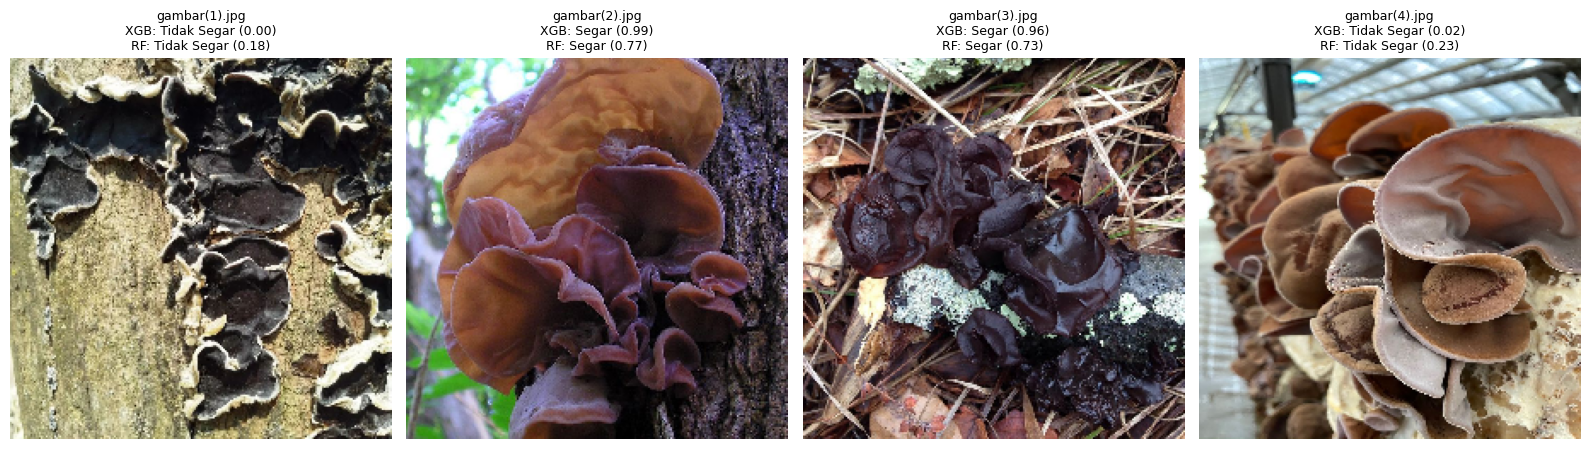


📋 Tabel Hasil Prediksi:
    Nama File XGBoost - Kelas XGBoost - Probabilitas Segar Random Forest - Kelas Random Forest - Probabilitas Segar
gambar(1).jpg     Tidak Segar                         0.00           Tidak Segar                               0.18
gambar(2).jpg           Segar                         0.99                 Segar                               0.77
gambar(3).jpg           Segar                         0.96                 Segar                               0.73
gambar(4).jpg     Tidak Segar                         0.02           Tidak Segar                               0.23


In [20]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import pandas as pd
import os

# Fungsi proses prediksi untuk satu gambar
def proses_gambar_dua_model(nama_file, model1, model2,
                            model1_name="XGBoost", model2_name="Random Forest",
                            pca_model=None, resnet_model=None):
    try:
        # Load & preprocessing gambar
        img = load_img(nama_file, target_size=(224, 224))
        arr = img_to_array(img)
        arr_exp = np.expand_dims(arr, axis=0)
        arr_pre = preprocess_input(arr_exp)

        # Ekstraksi fitur
        fitur = resnet_model.predict(arr_pre)
        if pca_model is not None:
            fitur = pca_model.transform(fitur)

        # Prediksi model 1 (XGBoost)
        pred1 = model1.predict(fitur)[0]
        proba1 = model1.predict_proba(fitur)[0]
        kelas1 = "Segar" if pred1 == 1 else "Tidak Segar"

        # Prediksi model 2 (Random Forest)
        pred2 = model2.predict(fitur)[0]
        proba2 = model2.predict_proba(fitur)[0]
        kelas2 = "Segar" if pred2 == 1 else "Tidak Segar"

        return img, os.path.basename(nama_file), kelas1, proba1[1], kelas2, proba2[1]

    except Exception as e:
        print(f"❌ Gagal memproses {nama_file}: {e}")
        return None, os.path.basename(nama_file), "Error", 0.0, "Error", 0.0

# Upload banyak gambar
uploaded = files.upload()

# Siapkan plot
jumlah_gambar = len(uploaded)
fig, axes = plt.subplots(1, jumlah_gambar, figsize=(4 * jumlah_gambar, 5))
if jumlah_gambar == 1:
    axes = [axes]

# Simpan hasil prediksi ke DataFrame
hasil_prediksi = []

# Loop semua gambar
for ax, nama_file in zip(axes, uploaded.keys()):
    img, fname, kelas1, prob1, kelas2, prob2 = proses_gambar_dua_model(
        nama_file,
        model1=xgb,
        model2=rf,
        model1_name="XGBoost + PCA",
        model2_name="Random Forest + PCA",
        pca_model=pca,
        resnet_model=resnet_model
    )

    if img is not None:
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(
            f"{fname}\nXGB: {kelas1} ({prob1:.2f})\nRF: {kelas2} ({prob2:.2f})",
            fontsize=9
        )

    # Simpan hasil ke list
    hasil_prediksi.append({
        "Nama File": fname,
        "XGBoost - Kelas": kelas1,
        "XGBoost - Probabilitas Segar": f"{prob1:.2f}",
        "Random Forest - Kelas": kelas2,
        "Random Forest - Probabilitas Segar": f"{prob2:.2f}"
    })

plt.tight_layout()
plt.show()

# Tampilkan tabel hasil prediksi
df_hasil = pd.DataFrame(hasil_prediksi)
print("\n📋 Tabel Hasil Prediksi:")
print(df_hasil.to_string(index=False))
